<a href="https://colab.research.google.com/github/valerio-unifei/UNIFEI-IA-Aulas/blob/main/Otimiza%C3%A7%C3%A3o_Evolutiva_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Otimização Evolutiva

<img src="https://user-images.githubusercontent.com/16560492/89446279-9c6f8380-d754-11ea-83fd-a60ea2f53b85.jpg" height="800">

## PYMOO - Multi Objetives Optimization

https://github.com/anyoptimization/pymoo

In [1]:
!pip install -U pymoo

     |████████████████████████████████| 2.5 MB 4.4 MB/s 
     |████████████████████████████████| 239 kB 52.1 MB/s 


### Uso Básico

* Problema = zdt1
* Algoritmo de otimização = NSGA2
* População = 100
* Gerações = 200

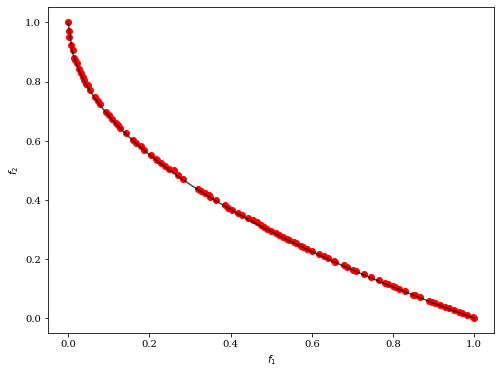

In [3]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# https://pymoo.org/problems/test_problems.html
problem = get_problem("zdt1")

# https://pymoo.org/algorithms/list.html
algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=42,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
_ = plot.show()

### Customizando Problema

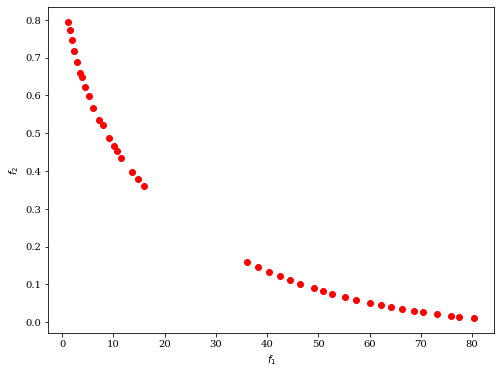

In [ ]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2] # notas
        out["G"] = [g1, g2] # restrição


problem = MyProblem()

algorithm = NSGA2(
      pop_size=40,
      n_offsprings=10,
      sampling=get_sampling("real_random"),
      crossover=get_crossover("real_sbx", prob=0.9, eta=15),
      mutation=get_mutation("real_pm", eta=20),
      eliminate_duplicates=True
  )

termination = get_termination("n_gen", 200)

res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=False,
               verbose=False)

plot = Scatter()
plot.add(res.F, color="red")
_ = plot.show()

### Problema de alocação ótima

Resolvendo um problema de seleção de local de instalação e tipo de loja (um tipo de problema de seleção de subconjunto) por algoritmo evolutivo usando o pacote pymoo

Autor: Samrat Nath

* https://pymoo.org/customization/discrete.html
* https://pymoo.org/problems/definition.html
* https://pymoo.org/algorithms/soo/ga.html#nb-ga

Melhor Solução: [0 1 0 1 0 0 0 0 0]
Valor da solução: [-11.]
Violação da restrição: [0.]


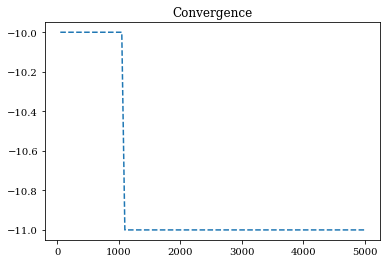

In [15]:
import numpy as np
from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.visualization.scatter import Scatter

# Mapas de estimativa financeira (em milhões)
S_mat = np.array([[75, 50, 25], [70, 40, 20], [65, 35, 15]])     # Vendas 
C_mat = np.array([[35, 20, 10], [35, 20, 10], [30, 18, 8]])     # Custos
N_mat = np.array([[10, 6, 4], [10, 5, 3], [9, 5, 3]])     # Valor Presente Líquido
I_mat = np.array([[3, 2, 1], [3, 2, 1], [3, 2, 1]])     # Impacto

# Representação vetorial das matrizes
sales, cost, npv, impact = S_mat.flatten(), C_mat.flatten(), N_mat.flatten(), I_mat.flatten()

# Restrições do Negócio (em milhões)
CAPEX_LIMIT = 55    # Limite de despesa de capital                            
MIN_MKT_SALES = 105  # Vendas mínimas do mercado

NUM_LOC = 3      # Numero possivel de locações das novas lojas
NUM_FMT = 3      # Numero tipos de lojas
STORE_LIMIT = 2  # Numero limite total de lojas

con_mat = np.zeros((NUM_FMT*NUM_LOC, NUM_LOC), dtype=int)
for i in range(NUM_LOC):
    con_mat[i*NUM_FMT:(i+1)*NUM_FMT,i] = 1 

#Problema
class LojasLocal(Problem):
    # Problema da mochila modificado
    def __init__(self):
        super().__init__(n_var = NUM_LOC*NUM_FMT,
                         n_obj = 1,
                         n_constr = NUM_LOC+2,
                         xl = 0,
                         xu = 1,
                         type_var = int
                         )

    def _evaluate(self, X, out, *args, **kwargs):
        # Objetivos e restrições
        out["F"] = -np.sum(X*(npv-impact), axis=1)
        g1 = np.sum(X*cost, axis=1) - CAPEX_LIMIT
        g2 = -(np.sum(X*sales, axis=1) - MIN_MKT_SALES)
        # restrição de formato de loja, 1 por locação
        g3 = (X@con_mat) -1 
        g4 = np.sum(X, axis=1) - STORE_LIMIT           
        out["G"] = np.column_stack([g1, g2, g3, g4]) 

# solução
# https://pymoo.org/algorithms/list.html
algoritmo = get_algorithm("nsga2",
                       pop_size=50,
                       sampling=get_sampling("int_random"),
                       crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
                       mutation=get_mutation("int_pm", eta=3.0),
                       eliminate_duplicates=True,
                       )

res = minimize(LojasLocal(),
               algoritmo,
               termination=('n_gen', 100),
               seed=42,
               save_history=True
               )

print("Melhor Solução: %s" % res.X)
print("Valor da solução: %s" % res.F)
print("Violação da restrição: %s" % res.CV)

# Soluções do Problema (Pop=2) 
# x = np.array([[0, 1, 0, 1, 0, 0, 0, 0, 0],
#               [0, 1, 0, 0, 0, 0, 1, 0, 0]])


import matplotlib.pyplot as plt
# numero de avaliações por geração
n_evals = np.array([e.evaluator.n_eval for e in res.history])  
# melhor avaliação por geração
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.show()

## Otimização Evolutiva em Deep Learning

https://pygad.readthedocs.io/en/latest/

In [17]:
!pip install pygad

     |████████████████████████████████| 53 kB 1.3 MB/s 


### Aprendizado Regressivo com Keras

Geração 1 Melhor nota: 7.924167892981052
Geração 2 Melhor nota: 7.924167892981052
Geração 3 Melhor nota: 7.924167892981052
Geração 4 Melhor nota: 7.924167892981052
Geração 5 Melhor nota: 7.924167892981052
Geração 6 Melhor nota: 7.924167892981052
Geração 7 Melhor nota: 8.433403953090377
Geração 8 Melhor nota: 14.354322394681796
Geração 9 Melhor nota: 14.354322394681796
Geração 10 Melhor nota: 14.354322394681796
Geração 11 Melhor nota: 65.0152402374109
Geração 12 Melhor nota: 65.0152402374109
Geração 13 Melhor nota: 65.0152402374109
Geração 14 Melhor nota: 65.0152402374109
Geração 15 Melhor nota: 65.0152402374109
Geração 16 Melhor nota: 65.0152402374109
Geração 17 Melhor nota: 65.0152402374109
Geração 18 Melhor nota: 65.0152402374109
Geração 19 Melhor nota: 65.0152402374109
Geração 20 Melhor nota: 65.0152402374109
Geração 21 Melhor nota: 66.03824886577497
Geração 22 Melhor nota: 66.03824886577497
Geração 23 Melhor nota: 66.03824886577497
Geração 24 Melhor nota: 66.03824886577497
Geração 

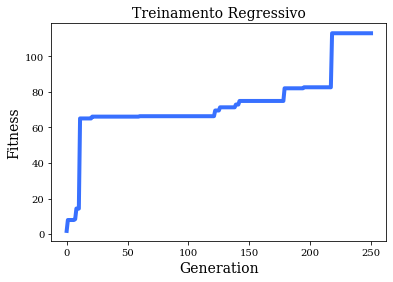

Melhor Solução = 112.91509862723069
Predição: 
 [[0.10112782]
 [0.62700784]
 [1.2991428 ]
 [2.506432  ]]
MAE:  0.008856202


In [20]:
import keras
import pygad.kerasga
import numpy
import pygad

# função de avaliação
def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model
    # pesos dos neurônios extraídos do indivíduo
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
    # inserindo pesos no modelo
    model.set_weights(weights=model_weights_matrix)
    # previsão do modelo
    predictions = model.predict(data_inputs)
    # erro da previsão em relação ao tutor
    mae = keras.losses.MeanAbsoluteError()
    abs_error = mae(data_outputs, predictions).numpy() + 0.00000001
    # avaliação
    solution_fitness = 1.0 / abs_error
    return solution_fitness

# impressão de geração
def callback_generation(ga_instance):
  generation=ga_instance.generations_completed
  bestFit=ga_instance.best_solution()[1]
  print(f'Geração {generation} Melhor nota: {bestFit}')

# modelo da rede 
input_layer  = keras.layers.Input(3)
dense_layer1 = keras.layers.Dense(5, activation="relu")(input_layer)
output_layer = keras.layers.Dense(1, activation="linear")(dense_layer1)
model = keras.Model(inputs=input_layer, outputs=output_layer)

# pesos dos neurônios do modelo
weights_vector = pygad.kerasga.model_weights_as_vector(model=model)

# problema
keras_ga = pygad.kerasga.KerasGA(model=model, num_solutions=10)

# Atributos de entrada
data_inputs = numpy.array([[0.02, 0.1, 0.15],
                           [0.7, 0.6, 0.8],
                           [1.5, 1.2, 1.7],
                           [3.2, 2.9, 3.1]])

# tutor regressivo
data_outputs = numpy.array([[0.1],
                            [0.6],
                            [1.3],
                            [2.5]])

num_generations = 250
num_parents_mating = 5
initial_population = keras_ga.population_weights

# otimização
ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)
ga_instance.run()

# resultados
ga_instance.plot_fitness(title="Treinamento Regressivo", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Melhor Solução = {solution_fitness}".format(solution_fitness=solution_fitness))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)
predictions = model.predict(data_inputs)
print("Predição: \n", predictions)

mae = keras.losses.MeanAbsoluteError()
abs_error = mae(data_outputs, predictions).numpy()
print("MAE: ", abs_error)

# Atividade 

## Enunciado

Dado seu número de matrícula, realize a otimização dos problemas selecionados com as técnicas sorteadas.

Use o código do problema alocação ótima como modelo.

In [23]:
import random

Matricula = 202200000 #@param {type:"integer"}
random.seed(Matricula)

# https://pymoo.org/problems/test_problems.html
problemas = ['Ackley','Griewank','Rastrigin','Rosenbrock','Zakharov']
# https://pymoo.org/algorithms/list.html
algortimos = ['ga','de','brkga','cmaes','sres','isres','nsga2','rnsga2']

random.shuffle(problemas)
random.shuffle(algortimos)

print('Problemas:', problemas[:2])
print('Otimizações:', algortimos[:3])

Problemas: ['Zakharov', 'Rosenbrock']
Otimizações: ['sres', 'isres', 'rnsga2']


## Solução